# 1.  Import python dependencies

In [1]:
import os
import json
import glob
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

import rasterio
import rasterio.plot

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

from pylandtemp import ndvi
from pylandtemp import emissivity
from pylandtemp import single_window

# 2. Set up location of data and types of data needed

The electromagnetic spectrum spans radio waves to gamma rays. Regions of the spectrum are defined by wavelength - the distance from the peak of one wave to the peak of the next wave. For radio waves, wavelength is large. The wavelength of x-rays and gamma rays is much shorter.

<img src="https://cdn.britannica.com/75/95275-050-5FC96002/Radio-waves-rays-light-gamma-ultraviolet-electromagnetic.jpg" alt="drawing" width="600" height="600"/>

<b>Spectral bands</b> are regions of the electromagnetic spectrum with a specific range of wavelengths. The LandSat spacecraft teams labels specfic ranges by number. The bands needed for calculating land surface temperature are:

- Red: Band 4
- Near-Infrared (NIR): Band 5
- Thermal infrared 1: Band 10
- Thermal infrared 2: Band 11

The data files use the letter 'B' followed by a number to indicate which bands are inside that file. For example, the 'B5' file has the near-infrared data.

Here, we search the directory of files looking for the four bands we need in our analysis.

In [2]:
# Get the list of all files in the directory
#subdir = '07-14-2023/'
#subdir = '07-30-2023/'
#subdir = '08-23-2023/'
subdir = '08-31-2023/'

path = "../Data/spacecraft/" + subdir
dir_list = glob.glob(path + "*")
prefix = dir_list[0].split('_T1')
prefix = prefix[0]

redband = prefix + "_T1_B4.TIF"
nirband = prefix + "_T1_B5.TIF"
tempband10 = prefix + "_T1_B10.TIF"
tempband11 = prefix + "_T1_B11.TIF"

#### Read each of these files into Python

In [3]:
with rasterio.open(redband) as src:
    redImage = src.read(1).astype('f4')

with rasterio.open(nirband) as src:
    nirImage = src.read(1).astype('f4')

with rasterio.open(tempband10) as src:
    tempImage10 = src.read(1).astype('f4')

with rasterio.open(tempband11) as src:
    tempImage11 = src.read(1).astype('f4')

# 3. Visualize the Red and NIR band images as a check that everything is working

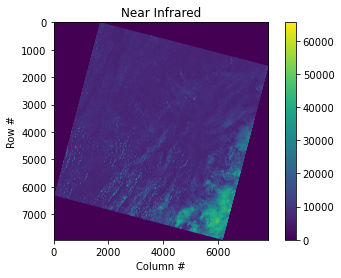

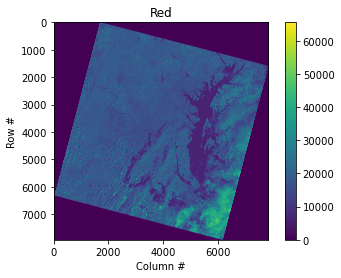

In [4]:
plt.imshow(redImage)
plt.colorbar()
plt.title('Near Infrared')
plt.xlabel('Column #')
plt.ylabel('Row #')
plt.show()

plt.imshow(nirImage)
plt.colorbar()
plt.title('Red')
plt.xlabel('Column #')
plt.ylabel('Row #')
plt.show()

# 4. Masking

There are times where the spacecraft does not collect data in some bands. The spacecraft will fill in 0 when it is unable to record data. The idea is that we do not want these 0 values to mistakenly be used in calculations. Here, we identify the location of all 0's and convert them to NaN (not a number), which tells Python not to use those locations in analysis. This process is referred to as "masking" because we hide non-valid data.

In [5]:
# Creating and applying the mask to the IR images.
mask = tempImage10 == 0
tempImage10[mask] = np.nan
tempImage11[mask] = np.nan

### Visualize the  thermal IR bands (10 and 11)

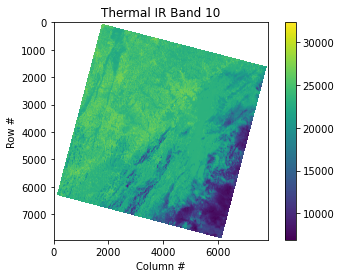

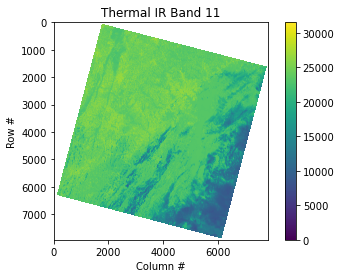

In [6]:
plt.imshow(tempImage10)
plt.colorbar()
plt.title('Thermal IR Band 10')
plt.xlabel('Column #')
plt.ylabel('Row #')
plt.show()

plt.imshow(tempImage11)
plt.colorbar()
plt.title('Thermal IR Band 11')
plt.xlabel('Column #')
plt.ylabel('Row #')
plt.show()

# 5. Compute NDVI

The Normalized Difference Vegetation Index (NDVI) is a remote sensing method that measures the amount and health of vegetation on land. The amount and health of vegetation directly relates to how hot the land surface will be.

In [7]:
mask = redImage == 0
ndviImage = ndvi(nirImage, redImage, mask=mask)

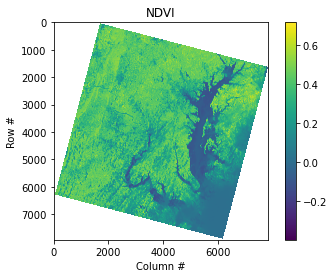

In [8]:
plt.imshow(ndviImage)
plt.colorbar()
plt.title('NDVI')
plt.xlabel('Column #')
plt.ylabel('Row #')
plt.show()

# 6. Compute Land Surface Temperature (LST)

In [9]:
lst = single_window(tempImage10, redImage, nirImage, unit='celcius')

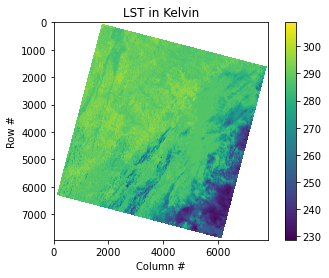

In [10]:
plt.imshow(lst)
plt.colorbar()
plt.title('LST in Kelvin')
plt.xlabel('Column #')
plt.ylabel('Row #')
plt.show()

# 7. Subset Baltimore

In [11]:
# Metadata is data about data. The metadta file contains useful
# information about how the data was recorded and the locations
# of each grid point

# metadata file is the one that ends with .json
metadataFile = glob.glob(path + "*_MTL.json")[0]

# read JSON file
f = open(metadataFile)
metadata = json.load(f)

# extract the portion of metadata dealing with location
projection = metadata['LANDSAT_METADATA_FILE']['PROJECTION_ATTRIBUTES']

# this value tells us how far (in kilometers) from one grid point to the next
stepSize = projection['GRID_CELL_SIZE_THERMAL']

# these values tell us the locations of the corners of our image
# UL = upper left, UR = upper right, LL = lower left, LR = lower right
UL_X = projection['CORNER_UL_PROJECTION_X_PRODUCT']
UL_Y = projection['CORNER_UL_PROJECTION_Y_PRODUCT']
UR_X = projection['CORNER_UR_PROJECTION_X_PRODUCT']
UR_Y = projection['CORNER_UR_PROJECTION_Y_PRODUCT']
LL_X = projection['CORNER_LL_PROJECTION_X_PRODUCT']
LL_Y = projection['CORNER_LL_PROJECTION_Y_PRODUCT']
LR_X = projection['CORNER_LR_PROJECTION_X_PRODUCT']
LR_Y = projection['CORNER_LR_PROJECTION_Y_PRODUCT']

In [12]:
print("Grid distance:", stepSize, 'kilometers')
print("Upper boundaries of image:", (UL_X, UL_Y), (UR_X, UR_Y))
print("Lower boundaries of image:", (LL_X, LL_Y), (LR_X, LR_Y))

Grid distance: 30.00 kilometers
Upper boundaries of image: ('219300.000', '4426500.000') ('454200.000', '4426500.000')
Lower boundaries of image: ('219300.000', '4188300.000') ('454200.000', '4188300.000')


In [13]:
# convert from strings to numbers
stepSize = int(float(stepSize))
UL_X = int(float(UL_X))
UR_X = int(float(UR_X))
LL_Y = int(float(LL_Y))
UL_Y = int(float(UL_Y))

# general bounding box of Baltimore
# while we're creating the locations we can flag locations that are likely Baltimore
northMost = 4359122.39
southMost = 4339514.16
westMost = 352207.54
eastMost = 368570.11

In [14]:
def checkBaltimore(x,y):

    if ( (x >= westMost) and (x <= eastMost) and
         (y >= southMost) and (y <= northMost) ):
        result = 1 # in Baltimore
    else:
        result = 0

    return result

In [15]:
gridXY = np.zeros( shape=(lst.shape[0], lst.shape[1],2) )
baltim = np.zeros( shape=(lst.shape[0], lst.shape[1]) )

gridXY[0,0,:] = [UL_X, UL_Y]
baltim[0,0] = checkBaltimore(UL_X, UL_Y)

x, y = UL_X, UL_Y
for row in range(1,lst.shape[0]):
    y -= stepSize

    if (row == 100): print("Working on row 100 of", lst.shape[0])
    if (row == 500): print("Working on row 500 of", lst.shape[0])
    if (row == 1000): print("Working on row 1000 of", lst.shape[0])
    if (row == 2500): print("Working on row 2500 of", lst.shape[0])
    if (row == 5000): print("Working on row 5000 of", lst.shape[0])

    for column in range(1,lst.shape[1]):
        x += stepSize
        gridXY[row,column,:] = [x,y]
        baltim[row,column] = checkBaltimore(x,y)
    x = UL_X

Working on row 100 of 7941
Working on row 500 of 7941
Working on row 1000 of 7941
Working on row 2500 of 7941
Working on row 5000 of 7941


In [16]:
# print out two corners to make sure everything is working
# the grid values and metadata values should be the same
print( gridXY[0,0], UL_X, UL_Y )
print( gridXY[-1,-1], LR_X, LR_Y )

[ 219300. 4426500.] 219300 4426500
[ 454200. 4188300.] 454200.000 4188300.000


In [17]:
rows, columns = np.where( baltim == 1 )
balt = lst[ rows, columns ]
ndvi = ndviImage[ rows, columns ]
baltXY = gridXY[ rows, columns, :]

balt.shape, ndvi.shape, baltXY.shape

((356430,), (356430,), (356430, 2))

# 8. Filter out poor quality pixels

The QA PIXEL file has quality control values for every pixel in the image. The get_mask function below reads the quality control values looking for indications of clouds, shadows, water, or missing values. If found, the pixel is removed.

In [18]:
file = glob.glob( path + "*_QA_PIXEL.TIF")[0]
qa = tiff.imread(file)
qa = np.array(qa)

Current quality control array is for the entire area. Subset to be just Baltimore.

In [19]:
qa = qa[rows, columns]
qa.shape

(356430,)

In [20]:
## See this tutorial
# https://towardsdatascience.com/removing-clouds-from-landsat-satellite-images-with-python-246e73494bc

def get_mask(val,type='cloud'):

    """Get mask for a specific cover type"""

    # convert to binary
    bin_ = '{0:016b}'.format(val)

    # reverse string
    str_bin = str(bin_)[::-1]

    # get bit for cover type
    bits = {'cloud':3,'shadow':4,'dilated_cloud':1,'cirrus':2,'fill':0,'water':7}
    bit = str_bin[bits[type]]

    if bit == '1':
        return 0 # cover
    else:
        return 1 # no cover

#### More Specific Subsetting of Baltimore area

In [21]:
baltimore = Polygon([   (352609.81, 4359122.39),
                        (352414.43, 4348800.59),
                        (360882.17, 4343758.90),
                        (363124.59, 4341011.75),
                        (366185.27, 4339682.13),
                        (367970.21, 4341028.39),
                        (368288.56, 4358841.12) ] )

In [22]:
poorQA = 0
baltLST = []
baltNDVI = []
baltLSTxy = []
for i in range( balt.shape[0] ):
    pos = baltXY[i,:]
    point = Point(pos[0], pos[1])

    # check this pixel for cloud cover, shadows, fill value, and water
    cmv = get_mask(qa[i], type='cloud')
    smv = get_mask(qa[i], type='shadow')
    dmv = get_mask(qa[i], type='dilated_cloud')
    civ = get_mask(qa[i], type='cirrus')
    fmv = get_mask(qa[i], type='fill')
    wmv = get_mask(qa[i], type='water')

    # if all values are 1 then this is a usable pixel
    if ( cmv and smv and dmv and civ and fmv and wmv ):
        quality = 1
    else:
        quality = 0
        poorQA += 1

    if (quality and baltimore.contains(point)):
        baltLST.append( balt[i] )
        baltNDVI.append( ndvi[i] )
        baltLSTxy.append( baltXY[i,:] )

baltLST = np.array(baltLST)
baltNDVI = np.array(baltNDVI)
baltLSTxy = np.array(baltLSTxy)
baltLST.shape, baltNDVI.shape, baltLSTxy.shape

((232558,), (232558,), (232558, 2))

In [23]:
print("Pixels removed due to QA:", poorQA)

Pixels removed due to QA: 36371


# 9. Visualize the results

Text(0.5, 1.0, 'LST in Baltimore (Kelvin)')

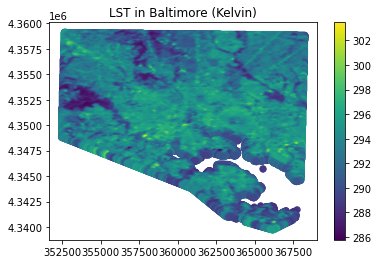

In [24]:
plt.scatter( baltLSTxy[:,0], baltLSTxy[:,1], c=baltLST )
plt.colorbar()
plt.title('LST in Baltimore (Kelvin)')

Text(0.5, 1.0, 'LST in Baltimore (F)')

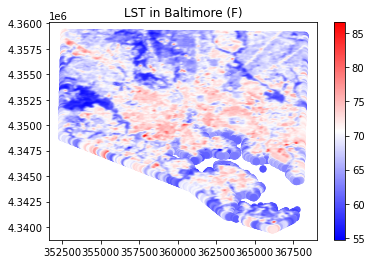

In [25]:
far = (baltLST - 273.15) * (9/5) + 32

plt.scatter( baltLSTxy[:,0], baltLSTxy[:,1], c=far )
plt.colorbar()
plt.set_cmap("bwr") # set colors to be blue to red
plt.title('LST in Baltimore (F)')

Text(0, 0.5, 'Frequency')

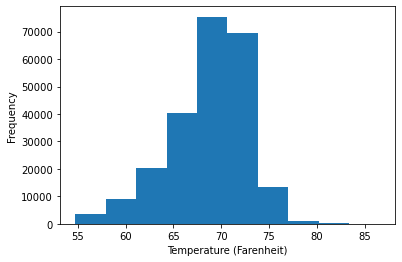

In [26]:
plt.hist( far )
plt.xlabel('Temperature (Farenheit)')
plt.ylabel('Frequency')

# 10. Show LST as Z-Scores

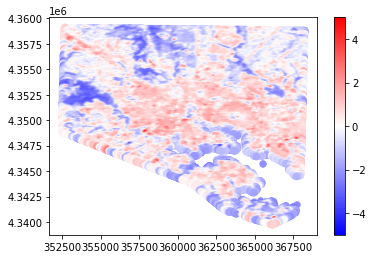

In [27]:
avg = np.mean(far)
std = np.std(far)
z = (far - avg) / std

plt.scatter( baltLSTxy[:,0], baltLSTxy[:,1], c=z )
plt.set_cmap("bwr") # set colors to be blue to red
plt.clim(-5,5) # set even range for colors to ensure zero in center
plt.colorbar()

In [28]:
print("Average Baltimore Temp:", avg)
print("Standard Deviation (degrees)", std)
print("Hottest location (z-score)", np.max(z))
ix = np.where( z == np.max(z) )
print("Hottest location (degrees)", far[ix][0])

Average Baltimore Temp: 68.75842
Standard Deviation (degrees) 4.0110874
Hottest location (z-score) 4.4433303
Hottest location (degrees) 86.58101


# 11. NDVI in Baltimore

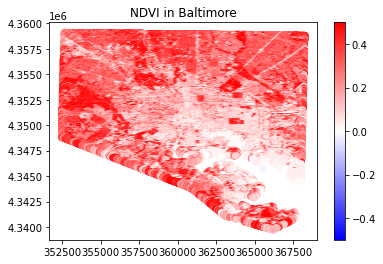

In [29]:
plt.scatter( baltLSTxy[:,0], baltLSTxy[:,1], c=baltNDVI )
plt.colorbar()
plt.title('NDVI in Baltimore')
plt.clim(-.5,.5) # set even range for colors to ensure zero in center

# 12. Write data to file for ML

In [30]:
# function to convert from UTM coordinates to latitude/longitude

import utm
zone = int( projection['UTM_ZONE'] )

def convertCoords( x, y, zone=zone ):

    lat, lon = utm.to_latlon( x, y, zone, 'N') # 'N' for Northern Hemisphere

    return lat, lon

In [31]:
date = metadata['LANDSAT_METADATA_FILE']['IMAGE_ATTRIBUTES']['DATE_ACQUIRED']
d = '../Data/LST/'
fname = d + 'LST_' + date + '.csv'

f = open(fname, 'w')
f.write('fahrenheit,zscore,ndvi,lstLat,lstLon\n')
for i in range(len(z)):
    lat, lon = convertCoords(baltLSTxy[i,0], baltLSTxy[i,1])
    line = str(far[i]) + ',' + str(z[i]) + ',' + str(baltNDVI[i]) + ',' + \
        str(lat) + ',' + str(lon)
    f.write(line + '\n')
f.close()
fname

'../Data/LST/LST_2023-08-31.csv'